# Init

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torchvision import datasets
from torchvision import transforms as T

In [22]:
# Get device for torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Dataset

In [3]:
# Data transforms
data_transform = T.Compose([T.ToTensor()])
target_transform = T.Compose([T.Lambda(lambda x:torch.LongTensor([x])), T.Lambda(lambda x:F.one_hot(x,10)), T.Lambda(lambda x: torch.flatten(x))])

In [4]:
# Download/read data
train_dataset = datasets.CIFAR10('./dataset', train=True, download=True, transform=data_transform, target_transform=target_transform)
test_dataset = datasets.CIFAR10('./dataset', train=False, download=True, transform=data_transform, target_transform=target_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create DataLoaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [6]:
# Labels map
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

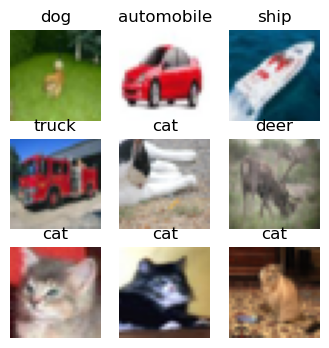

In [7]:
# Inspect random datapoints
figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[torch.argmax(label).item()])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(), 0, 2))
plt.show()

# Model

In [8]:
# Class for neural net model
class CifarCNN(nn.Module):

    # Constructor
    def __init__(self):
        super().__init__()

        # Create network
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10)
        )

        # Initialize weights for all layers in the model
        self.initialize_weights()

    # Intitialize weights
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                # Apply your chosen initialization method
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    # Forward pass
    def forward(self, input):
        return self.network(input)

    # Training step
    def compute_batch_metrics(self, batch):

        # Get output
        (X, y) = batch
        outputs = self(X)

        # Calculate and return loss & accuracy
        loss = F.cross_entropy(outputs, y.float())
        accuracy = ((outputs.argmax(1) == y.argmax(1)).type(torch.float).sum())/len(X)
        return loss, accuracy

In [9]:
# Function to train one epoch
def train_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    size_d = len(str(size))
    num_batches = len(dataloader)
    loss_sum = 0
    accuracy_sum = 0

    # Set model training mode
    model.train()

    # Loop batches
    for batch, (X, y) in enumerate(dataloader):

        # Move data to device
        X, y = X.to(device), y.to(device)

        # Calculate loss and accuracy
        loss, accuracy = model.compute_batch_metrics((X, y))
        loss_sum += loss.item()
        accuracy_sum += accuracy.item()
        
        # Optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print batch stats
        current = (batch + 1) * len(X)
        print(f"loss: {loss:>7f}, acc: {accuracy:>7f}  [{current:>{size_d}d}/{size:>{size_d}d}]")

    # Calculate average loss and accuracy
    avg_loss = loss_sum / num_batches
    avg_accuracy = accuracy_sum / num_batches

    # Return average loss and accuracy
    return avg_loss, avg_accuracy

In [10]:
# Test function to run every epoch
def test_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    accuracy_sum = 0

    # Set model evaluation mode
    model.eval()

    # Calulate loss
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            loss, accuracy = model.compute_batch_metrics((X, y))
            test_loss += loss.item()
            accuracy_sum += accuracy.item()

    # Get accuracy and avg batch loss
    avg_loss = test_loss / num_batches
    accuracy = accuracy_sum / num_batches
    
    # Print loss
    print(f"\nTest Error: \nAccuracy: {(100*accuracy):>0.1f}%, \nAvg loss: {avg_loss:>8f} \n")
    
    # Return accuracy and average batch loss
    return avg_loss, accuracy

In [11]:
# Train function
def train(train_data_loader, test_data_loader, model, optimizer, epochs, **options):

    # Initialize data
    initial_epoch = options['initial_epoch'] if 'initial_epoch' in options else 0
    metrics = options['metrics'] if 'metrics' in options else []

    # Run epochs
    for epoch in range(initial_epoch, epochs):

        # Log epoch details
        print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")
    
        # Train model
        train_loss, train_accuracy = train_model(train_data_loader, model, optimizer)
    
        # Test model
        test_loss, test_accuracy = test_model(test_data_loader, model, optimizer)
    
        # Add metrics to array
        metrics.append({
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy
        })

    # Return metrics
    metrics

# Training

In [12]:
# Hyperparameters
learning_rate = 0.05
epochs = 200

In [14]:
# Model
model = CifarCNN()
model.to(device)

CifarCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=512, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=512, out_features=64, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [15]:
# Optimizer
optimizer = SGD(model.parameters(), lr=learning_rate)

In [16]:
# Initialize metrics array
metrics = []

Cleared output for all but last training to keep the notebook clean

In [56]:
# # Train for `epochs` epochs - 200
# train(train_data_loader, test_data_loader, model, optimizer, epochs, metrics=metrics, initial_epoch=0)

In [55]:
# # Train for 200 more epochs
# train(train_data_loader, test_data_loader, model, optimizer, 400, metrics=metrics, initial_epoch=200)

In [59]:
# # Train for 200 more epochs
# train(train_data_loader, test_data_loader, model, optimizer, 600, metrics=metrics, initial_epoch=400)

In [53]:
# # Train for 200 more epochs
# train(train_data_loader, test_data_loader, model, optimizer, 800, metrics=metrics, initial_epoch=600)

In [52]:
# # Train for 400 more epochs
# train(train_data_loader, test_data_loader, model, optimizer, 1200, metrics=metrics, initial_epoch=800)

In [61]:
# # Train for 400 more epochs
# train(train_data_loader, test_data_loader, model, optimizer, 1600, metrics=metrics, initial_epoch=1200)

In [62]:
# # Train till 1800 epochs
# train(train_data_loader, test_data_loader, model, optimizer, 1800, metrics=metrics, initial_epoch=1600)

In [39]:
# Train till 1800 epochs
train(train_data_loader, test_data_loader, model, optimizer, 2000, metrics=metrics, initial_epoch=1800)

Epoch 1801/2000
-------------------------------
loss: 0.967522, acc: 0.668600  [10000/50000]
loss: 0.929305, acc: 0.678000  [20000/50000]
loss: 0.919789, acc: 0.688600  [30000/50000]
loss: 0.883607, acc: 0.695400  [40000/50000]
loss: 0.892142, acc: 0.694100  [50000/50000]

Test Error: 
Accuracy: 68.6%, 
Avg loss: 0.918249 

Epoch 1802/2000
-------------------------------
loss: 0.911372, acc: 0.685400  [10000/50000]
loss: 0.897335, acc: 0.681000  [20000/50000]
loss: 0.909238, acc: 0.687800  [30000/50000]
loss: 0.916931, acc: 0.679900  [40000/50000]
loss: 0.930797, acc: 0.676700  [50000/50000]

Test Error: 
Accuracy: 66.7%, 
Avg loss: 0.964676 

Epoch 1803/2000
-------------------------------
loss: 0.973572, acc: 0.661800  [10000/50000]
loss: 0.940480, acc: 0.674400  [20000/50000]
loss: 0.954337, acc: 0.671500  [30000/50000]
loss: 0.922628, acc: 0.680800  [40000/50000]
loss: 0.948360, acc: 0.664100  [50000/50000]

Test Error: 
Accuracy: 68.1%, 
Avg loss: 0.935275 

Epoch 1804/2000
------

# Metrics

In [26]:
# Plot metrics
def plot_metrics(metrics):

    # Create dataframe
    df = pd.DataFrame(metrics)

    # Create sub plots
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax1 = axes[0]
    ax2 = axes[1]

    # Loss plot
    sns.set_style('whitegrid')
    sns.set_palette('tab10')
    sns.lineplot(df['train_loss'], label='Train', ax=axes[0])
    sns.lineplot(df['test_loss'], label='Test', ax=axes[0])
    ax1.set_title('Train and test losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    # Accuracy plot
    sns.set_style('whitegrid')
    sns.set_palette('tab10')
    sns.lineplot(df['train_accuracy'], label='Train', ax=axes[1])
    sns.lineplot(df['test_accuracy'], label='Test', ax=axes[1])
    ax2.set_title('Train and test accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    # Set layout and show plot
    plt.tight_layout()
    plt.show()

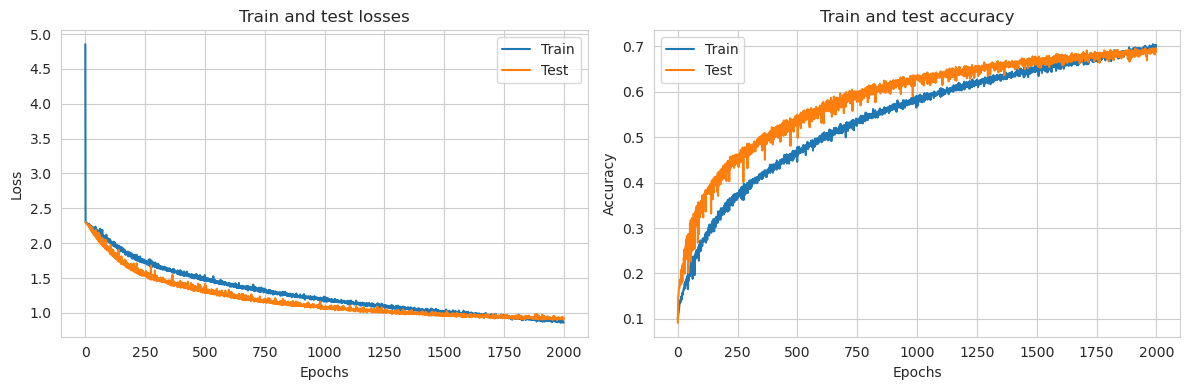

In [40]:
plot_metrics(metrics)

# Save model

In [47]:
# Save model to load again for training/inference
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'metrics': metrics
}
torch.save(checkpoint, 'model_2000e.pth')

In [45]:
# Load model file
loaded_checkpoint = torch.load('model_2000e.pth')

In [46]:
# Load model details from checkpoint
loaded_model = CifarCNN()
loaded_optimizer = SGD(loaded_model.parameters(), lr=0.05)
loaded_model.load_state_dict(loaded_checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
loaded_metrics = loaded_checkpoint['metrics']